## xESMF graveyard
Cut from Step2.  Save for possible revisiting later...xESMF seems cool, if only it would work!

## Reproject obs to match CESM grid -- with xESMF
Use `xe.Regridder` with an input grid and output grid to do just the one transformation. No depth slicing!  Note that we are transforming EN4 to the CESM2 grid and not vice versa -- much more efficient.

Note 18 Sept: datasets should have extra dimensions (other than lat/lon) on the left.  CESM dataset `test_ds_full` did not, but DataArray `test_ds_full.TF` does. Check this and transpose dimension order if necessary before regridding.
- Rename nlat, nlon so that xESMF does not confuse them with lat, lon?

In [52]:
tds = test_ds_full.TF.rename({'nlat': 'num_y', 'nlon': 'num_x'})
tds.dims

('time', 'depth', 'num_y', 'num_x')

In [69]:
regridder = xe.Regridder(tobs_ds_full, 
                         tds, 
                         "patch")
regridder

xESMF Regridder 
Regridding algorithm:       patch 
Weight filename:            patch_30x91_47x320.nc 
Reuse pre-computed weights? False 
Input grid shape:           (30, 91) 
Output grid shape:          (47, 320) 
Periodic in longitude?      False

In [70]:
obs_ds_out = regridder(tobs_ds_full, keep_attrs=True)

/Users/eultee/miniforge3/envs/odata/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [71]:
obs_ds_out.mean()

<xarray.DataArray 'TF' ()> Size: 8B
array(0.74265519)

Text(0.5, 0.98, 'June 1984 - 10m depth')

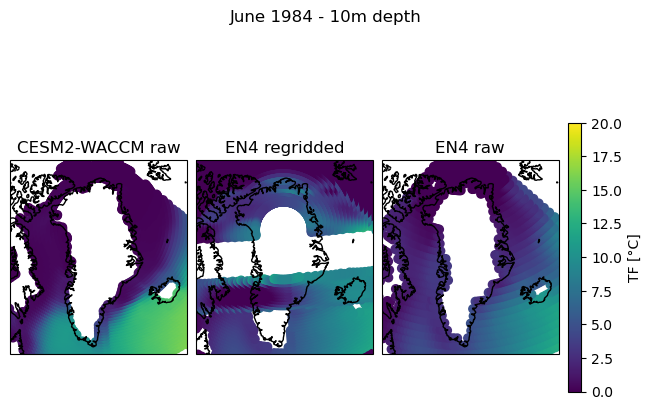

In [72]:
depth_toplot=10
TF_toplot_sim = test_ds_full.TF.sel(time='1984-06-30', depth=depth_toplot, method='nearest')
TF_toplot_obs = obs_ds_out.sel(time='1984-06-30', depth=depth_toplot, method='nearest')
TF_toplot_obsraw = tobs_ds_full.sel(time='1984-06-30', depth=depth_toplot, method='nearest')


# obs_x, obs_y = np.meshgrid(tobs_ds_full.lon, tobs_ds_full.lat)

### Limits of Greenland domain ###
limN           = 86.0 ## degrees N latitude
limS           = 57.0 ## degrees N latitude
limE           = 4.0 ## degrees E latitude
limW           = 274.0 ## degrees E latitude

GrIS_polar_stereo = ccrs.Stereographic(
            central_latitude=90.0,
            central_longitude=-45.0,
            false_easting=0.0,
            false_northing=0.0,
            true_scale_latitude=70.0,
            globe=ccrs.Globe('WGS84')
        )

fig, axs = plt.subplots(1,3, layout='constrained',
                        subplot_kw={'projection': GrIS_polar_stereo, 'extent':  [-65, -20, limS, limN]})

sc_sim = axs[0].scatter(y=test_ds_full.lat, x=test_ds_full.lon, c=TF_toplot_sim, transform=ccrs.PlateCarree(),
          cmap='viridis', vmin=0., vmax=20.);
axs[0].set(aspect=1, title='CESM2-WACCM raw')
axs[0].coastlines()
# cbar1 = plt.colorbar(sc_sim, orientation='vertical', label='TF [°C]')

sc_obs = axs[1].scatter(y=test_ds_full.lat, x=test_ds_full.lon, c=TF_toplot_obs, transform=ccrs.PlateCarree(),
          cmap='viridis', vmin=0., vmax=20.);
axs[1].set(aspect=1, title='EN4 regridded')
axs[1].coastlines()
# cbar2 = plt.colorbar(sc_obs, orientation='vertical', label='TF [°C]', shrink=0.6)

sc_obsraw = axs[2].scatter(y=obs_y, x=obs_x, c=TF_toplot_obsraw, transform=ccrs.PlateCarree(),
          cmap='viridis', vmin=0., vmax=20.);
axs[2].set(aspect=1, title='EN4 raw')
axs[2].coastlines()
cbar2 = plt.colorbar(sc_obsraw, orientation='vertical', label='TF [°C]', shrink=0.6)

fig.suptitle('June 1984 - {}m depth'.format(depth_toplot))

Note Aug 30 2025: the regridding "works", but the regridded EN4 looks questionable using `bilinear` or `patch` options. Areas of missing data are large and weird.  Tried `conservative` but need a different data format (grid corners, I think).  

19 Sep: The xESMF regridding does not seem to work for our purposes.  Donald and Denis working on brute-force regridding.  Return to QDM with data pre-gridded to rectangular EPSG:3413.